<a href="https://colab.research.google.com/github/sebamiles/IAPred/blob/main/IApred-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title # 1) Download and Install dependencies
import pkg_resources
import subprocess
import sys
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


def install_if_needed(package):
    try:
        pkg_resources.require(package)
    except pkg_resources.DistributionNotFound:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package],
                            stdout=subprocess.DEVNULL,
                            stderr=subprocess.DEVNULL)

# Suppress output with context manager
class SuppressOutput:
    def __enter__(self):
        self._stdout = sys.stdout
        self._stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, *args):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._stdout
        sys.stderr = self._stderr

with SuppressOutput():
    # Install required packages
    install_if_needed('biopython')

    # Import required packages
    import numpy as np
    from Bio import SeqIO
    import csv
    from Bio.SeqUtils.ProtParam import ProteinAnalysis
    from collections import Counter
    import re
    from joblib import load
    from sklearn.feature_selection import VarianceThreshold
    from sklearn.inspection import permutation_importance
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap

    # Clean up existing files
    os.system('rm -rf models protein_motifs4.txt functions.py')

    # Download and setup repository contents (latest version)
    os.system('wget -q https://github.com/sebamiles/IAPred/archive/main.zip')
    os.system('unzip -q main.zip')

    # Move required files
    os.system('mv IAPred-main/models .')
    os.system('mv IAPred-main/protein_motifs.txt .')
    os.system('mv IAPred-main/functions.py .')

    # Clean up temporary files
    os.system('rm -rf IAPred-main main.zip')

    # Import functions
    from functions import *

print("Dependencies installed correctly")

<ipython-input-1-f58345a09794>:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Dependencies installed correctly



Intrinsic Antigenicity: 0.31 (High)


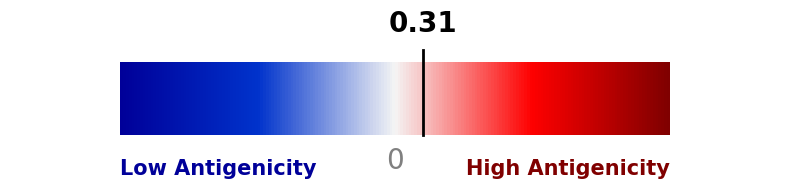

In [2]:
#@title # 2) Input a single amino acid sequence or leave it blank to upload a fasta file (upload button below the cell)
from functions import *
from google.colab import files  # Add this import
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import csv
import os
from joblib import load
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

def evaluate_single_sequence(sequence, model, scaler, variance_selector, feature_selector, feature_mask, all_feature_names):
    try:
        # Get the score and invert it by multiplying by -1
        score = evaluate_sequence(sequence, model, scaler, variance_selector, feature_selector, feature_mask, all_feature_names)
        inverted_score = -1 * score  # Invert the score

        # Determine category based on inverted score
        if inverted_score < -0.3:
            category = "Low"
        elif inverted_score > 0.3:
            category = "High"
        else:
            category = "Moderate"

        return inverted_score, category
    except Exception as e:
        return None, str(e)


def create_score_visualization(score):

    # Create the plot
    colors = ['#000099', '#0033cc', '#F5F5F5', '#ff0000', '#800000']
    n_bins = 200
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    fig, ax = plt.subplots(figsize=(8, 2))
    fig.patch.set_facecolor('white')
    gradient = np.linspace(-3, 3, 400).reshape(1, -1)
    ax.imshow(gradient, cmap=cmap, aspect='auto', extent=[-3, 3, 0, 0.6])

    # Add a marker for the score
    ax.plot([score, score], [0, 0.7], color='black', linewidth=2)
    ax.text(score, 0.8, f'{score:.2f}', ha='center', va='bottom', fontsize=20,
            fontweight='bold', fontfamily='sans-serif', color='black')

    # Add text for low and high antigenicity
    ax.text(-3, -0.2, 'Low Antigenicity', ha='left', va='top', fontsize=15,
            fontweight='bold', fontfamily='sans-serif', color='#000099')
    ax.text(3, -0.2, 'High Antigenicity', ha='right', va='top', fontsize=15,
            fontweight='bold', fontfamily='sans-serif', color='#800000')

    # Add a '0' below the center of the bar
    ax.text(0, -0.1, '0', ha='center', va='top', fontsize=20,
            fontfamily='sans-serif', color='gray')

    # Set the axis limits and remove ticks
    ax.set_xlim(-4.2, 4.2)
    ax.set_ylim(-0.3, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove axis spines
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    return fig

def create_ascii_visualization(score):
    """
    Create an ASCII visualization with indicator position based on dashes
    and centered score display.
    """
    # Create the base visualization with exactly 30 dashes on each side
    left_side = "-" * 30
    right_side = "-" * 30

    # Insert the category markers after the third dash from zero on each side
    left_with_marker = left_side[:-3] + "|" + left_side[-3:]
    right_with_marker = right_side[:3] + "|" + right_side[3:]

    # Calculate dash position (-3.0 to +3.0 maps to 0 to 60 dashes)
    dash_position = int((score + 3.0) * 10)  # Each dash represents 0.1 units

    # Adjust position for markers and zero
    if score <= -0.3:
        position = dash_position
    elif score < 0:
        position = dash_position + 1
    elif score <= 0.3:
        position = dash_position + 2
    else:
        position = dash_position + 3

    # Clamp position to valid range
    position = max(0, min(63, position))  # 63 = 60 dashes + 2 markers + zero

    # Create score string with fixed width
    score_str = f"{score:.2f}"

    # Create the visualization
    visualization = "Low                        Moderate                        High\n"
    visualization += f"[{left_with_marker}0{right_with_marker}]\n"

    # Calculate the center position for the score
    score_offset = len(score_str) // 2
    padding = position - score_offset

    # Add pointer and score
    visualization += ' ' * position + "^\n"  # Pointer on its own line
    visualization += ' ' * padding + score_str  # Centered score below

    return visualization


def process_fasta_file(fasta_content, output_csv, model, scaler, variance_selector,
                      feature_selector, feature_mask, all_feature_names, long_output=True, color_scale=False):

    results = []
    low_antigenicity_count = 0
    moderate_antigenicity_count = 0
    high_antigenicity_count = 0

    # Parse sequences from the content
    sequences = []
    current_header = ''
    current_sequence = ''

    for line in fasta_content.split('\n'):
        line = line.strip()
        line = ''.join(c for c in line if c.isprintable() and ord(c) < 128)
        if line.startswith('>'):
            if current_header and current_sequence:
                sequences.append((current_header, current_sequence))
            current_header = line[1:]
            current_sequence = ''
        elif line:
            current_sequence += line

    # Add the last sequence
    if current_header and current_sequence:
        sequences.append((current_header, current_sequence))

    total_sequences = len(sequences)
    print(f"Found {total_sequences} sequences")

    # Create/open CSV file for writing results
    with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Header', 'Sequence_Length', 'IAScore', 'Antigenicity_Category'])

        for i, (header, sequence) in enumerate(sequences, 1):
            header = header[:20]
            score, category = evaluate_single_sequence(sequence, model, scaler,
                                                    variance_selector, feature_selector,
                                                    feature_mask, all_feature_names)

            if score is None:
                print(f"\nWarning: {category} for {header}")
                csv_writer.writerow([header, len(sequence) if sequence else 0, category, "N/A"])
                continue

            if long_output:
                print(f"\nProcessing sequence {i}/{total_sequences}: {header}")
                print(f"Intrinsic Antigenicity: {score:.2f} ({category})")
                if color_scale:
                    fig = create_score_visualization(score)
                    plt.show()
                    plt.close(fig)
                else:
                    print(create_ascii_visualization(score))
            else:
                print(f"\rProcessing: {i}/{total_sequences} - {header}: {score:.2f} ({category})", end='')

            csv_writer.writerow([header, len(sequence), f"{score:.2f}", category])
            results.append((header, score, category))

            if category == "Low":
                low_antigenicity_count += 1
            elif category == "High":
                high_antigenicity_count += 1
            else:
                moderate_antigenicity_count += 1

    if not long_output:
        print()

    print(f"\nAntigenicity Summary:")
    print(f"Low Antigenicity (score < -0.3): {low_antigenicity_count} sequences")
    print(f"Moderate Antigenicity (-0.3 to 0.3): {moderate_antigenicity_count} sequences")
    print(f"High Antigenicity (score > 0.3): {high_antigenicity_count} sequences")

    return results

def main(sequence="", long_output=True, save_results=True, color_scale=False):

    # Load models
    models_folder = "models"
    if not os.path.isdir(models_folder):
        print(f"Error: The '{models_folder}' folder does not exist in the current directory.")
        return

    try:
        svm_model = load(os.path.join(models_folder, 'IApred_SVM.joblib'))
        scaler = load(os.path.join(models_folder, 'IApred_scaler.joblib'))
        variance_selector = load(os.path.join(models_folder, 'IApred_variance_selector.joblib'))
        feature_selector = load(os.path.join(models_folder, 'IApred_feature_selector.joblib'))
        feature_mask = load(os.path.join(models_folder, 'IApred_feature_mask.joblib'))
        all_feature_names = load(os.path.join(models_folder, 'IApred_all_feature_names.joblib'))
    except Exception as e:
        print(f"Error loading model files: {str(e)}")
        return

    if sequence.strip():
        score, category = evaluate_single_sequence(sequence, svm_model, scaler,
                                                variance_selector, feature_selector,
                                                feature_mask, all_feature_names)

        if score is not None:
            if long_output:
                print(f"\nIntrinsic Antigenicity: {score:.2f} ({category})")
                if color_scale:
                    fig = create_score_visualization(score)
                    plt.show()
                    plt.close(fig)
                else:
                    print(create_ascii_visualization(score))
            else:
                print(f"Score: {score:.2f} ({category})")
        else:
            print(f"\nError: {category}")

    else:
        print("Please upload your FASTA file:")
        uploaded = files.upload()

        if not uploaded:
            print("No file was uploaded.")
            return

        filename = list(uploaded.keys())[0]
        content = uploaded[filename].decode('utf-8')
        output_csv = os.path.splitext(filename)[0] + '_results.csv'

        results = process_fasta_file(content, output_csv, svm_model, scaler,
                                   variance_selector, feature_selector,
                                   feature_mask, all_feature_names,
                                   long_output, color_scale)

        if save_results:
            print(f"\nResults have been saved to {output_csv}")
            files.download(output_csv)
        else:
            if os.path.exists(output_csv):
                os.remove(output_csv)

#  Usage:
if __name__ == "__main__":

    #@markdown # Input a single sequence
    sequence = "" # @param {"type":"string"}
    #@markdown Print a long output with an IAscore scalebare for each sequence
    long_output = True # @param {"type":"boolean"}
    #@markdown # Prompt a download of .csv results (Only for multiple sequences analysis)
    save_results = False # @param {"type":"boolean"}
    #@markdown # Replace the ASCII scale bar with a color .png one
    color_scale = True  # @param {"type":"boolean"}

    main(sequence=sequence, long_output=long_output, save_results=save_results, color_scale=color_scale)